# Explorative  Analysis

## Import packages

In [1]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)


## Plot parameters

In [2]:
sns.set_palette(['silver', 'skyblue', 'darkorange'], n_colors=3)
sns.despine(right=False, top=False)

plt.rcParams.update({'font.size': 18,
                     'axes.edgecolor': 'gray',
                     'axes.labelcolor': 'gray',
                     'axes.labelweight': 'ultralight',
                     'xtick.color': 'gray',
                     'xtick.labelsize': 'small',
                     'ytick.color': 'gray',
                     'ytick.labelsize': 'small',
                     'axes.titlelocation': 'center',
                     'yaxis.labellocation': 'top',
                     'patch.edgecolor': 'gray',
                     'axes.titlecolor': 'dimgray',
                     'axes.formatter.useoffset': False,
                     'axes.formatter.use_mathtext': True,
                     'figure.facecolor': 'white',
                     'axes.facecolor': 'white',
                     'savefig.facecolor': 'white',
                     "axes.labelsize": 18,
                     'figure.figsize': [8, 8]
                     }
                    )

# plt.rcParams.keys()


<Figure size 432x288 with 0 Axes>

## Read data
- The dataset has 21983 rows and 30 columns
- Every row of the dataset represents one customer who has registered to use the service during September 2019 and either has or hasn’t made orders during the time from then and October 2020.

In [3]:
# Path of the csv file containing wolt user data
user_data_path = "data\dataset_for_analyst_assignment_20201120.csv"

# Read provided data from csv file
user_data_df = pd.read_csv(user_data_path)


In [4]:
# Check dataset size
user_data_df.shape


(21983, 30)

In [5]:
# Check first 5 rows of teh raw data
user_data_df.head()


,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


## Data wrangling

In [6]:
# Change data type to date for columns representing a date
user_data_df[["REGISTRATION_DATE", "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY"]] = user_data_df[[
    "REGISTRATION_DATE", "FIRST_PURCHASE_DAY", "LAST_PURCHASE_DAY"]].apply(pd.to_datetime)

# Check column data types
user_data_df.dtypes


REGISTRATION_DATE                          datetime64[ns]
REGISTRATION_COUNTRY                               object
PURCHASE_COUNT                                      int64
PURCHASE_COUNT_DELIVERY                           float64
PURCHASE_COUNT_TAKEAWAY                           float64
FIRST_PURCHASE_DAY                         datetime64[ns]
LAST_PURCHASE_DAY                          datetime64[ns]
USER_ID                                             int64
BREAKFAST_PURCHASES                               float64
LUNCH_PURCHASES                                   float64
EVENING_PURCHASES                                 float64
DINNER_PURCHASES                                  float64
LATE_NIGHT_PURCHASES                              float64
TOTAL_PURCHASES_EUR                               float64
DISTINCT_PURCHASE_VENUE_COUNT                     float64
MIN_PURCHASE_VALUE_EUR                            float64
MAX_PURCHASE_VALUE_EUR                            float64
AVG_PURCHASE_V

### Explode column PURCHASE_COUNT_BY_STORE_TYPE

In [7]:
# Data frame with columns purchase count for each store type
store_type_df = (user_data_df["PURCHASE_COUNT_BY_STORE_TYPE"].replace('\n', '', regex=True)
                 .apply(ast.literal_eval)
                 .apply(pd.Series)
                 .rename(columns={"General merchandise": "PURCHASE_COUNT_GENERAL_MERCHANDISE",
                                  "Grocery": "PURCHASE_COUNT_GROCERY",
                                  "Pet supplies": "PURCHASE_COUNT_PET_SUPPLIES",
                                  "Restaurant": "PURCHASE_COUNT_RESTAURANT",
                                  "Retail store": "PURCHASE_COUNT_RETAIL_STORE"})
                 )

# Remove old column for PURCHASE_COUNT_BY_STORE_TYPE and add the individual columns with purchase count for each store type
user_data_df = pd.concat([user_data_df.drop(
    ["PURCHASE_COUNT_BY_STORE_TYPE"], axis=1), store_type_df], axis=1)


### Check data quality


#### Missing values
- The columns REGISTRATION_COUNTRY, PURCHASE_COUNT, PURCHASE_COUNT_BY_STORE_TYPE, USER_ID, USER_HAS_VALID_PAYMENT_METHOD, REGISTRATION_DATE have no missing data
- Most columns for users that made no purchase are expected to be empty
- PREFERRED_RESTAURANT_TYPES has 87.7% missing values

In [8]:
# Sum all missing values for each column
total = user_data_df.isnull().sum().sort_values(ascending=False)

# Calculate the percentage of missing values for each column
percent = round(user_data_df.isnull().sum(
)/user_data_df.isnull().count()*100, 1).sort_values(ascending=False)

# Create a data frame containing the total number of missing values and the % out of the total number of values
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])

# Check the % of missing values for each column
missing_data


,Total,%
PREFERRED_RESTAURANT_TYPES,19289,87.7
MEDIAN_DAYS_BETWEEN_PURCHASES,14151,64.4
AVG_DAYS_BETWEEN_PURCHASES,14151,64.4
FIRST_PURCHASE_DAY,10019,45.6
LAST_PURCHASE_DAY,9956,45.3
MAX_PURCHASE_VALUE_EUR,9955,45.3
AVG_PURCHASE_VALUE_EUR,9955,45.3
LUNCH_PURCHASES,9955,45.3
EVENING_PURCHASES,9955,45.3
DINNER_PURCHASES,9955,45.3


##### Missing values for users that made at least one purchase
- PREFERRED_RESTAURANT_TYPES has a high share of missing values even for users that made at least one purchase

In [9]:
# Sum all missing values for each column
total = user_data_df.query("PURCHASE_COUNT > 0").isnull(
).sum().sort_values(ascending=False)

# Calculate the percentage of missing values for each column
percent = round(user_data_df.query("PURCHASE_COUNT > 0").isnull().sum(
)/user_data_df.query("PURCHASE_COUNT > 0").isnull().count()*100, 1).sort_values(ascending=False)

# Create a data frame containing the total number of missing values and the % out of the total number of values
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])

# Check the % of missing values for each column
missing_data.query("Total > 0")


,Total,%
PREFERRED_RESTAURANT_TYPES,9362,77.8
MEDIAN_DAYS_BETWEEN_PURCHASES,4196,34.9
AVG_DAYS_BETWEEN_PURCHASES,4196,34.9
FIRST_PURCHASE_DAY,64,0.5
LAST_PURCHASE_DAY,1,0.0
PREFERRED_DEVICE,1,0.0


#### Is registration date during September 2019?
- Yes all registration dates are during 2019-09

In [10]:
# Check if all registration dates are from 2019-09
registration_date_s = user_data_df["REGISTRATION_DATE"].dt.to_period('M')
set(registration_date_s)


{Period('2019-09', 'M')}

#### Are all user_ids unique?
- Yes all user_ids are unique

In [11]:
# Users IDs count and distinct count to check for duplicates
user_data_df.agg(count_users=("USER_ID", "count"),
                 distinct=("USER_ID", "nunique"))


,USER_ID
count_users,21983
distinct,21983


#### Are there any negative purchase_count?
- no negative values as expected

In [12]:
# Count negative purchases
user_data_df.query("PURCHASE_COUNT < 0")["PURCHASE_COUNT"].count()


0

#### Is purchase_count = ios_purchase + web_purchases + android_purchases?
- Yes

In [13]:
# Check if ios_purchase + web_purchases + android_purchases
user_data_df.query(
    "PURCHASE_COUNT != IOS_PURCHASES + WEB_PURCHASES + ANDROID_PURCHASES and PURCHASE_COUNT > 0")["PURCHASE_COUNT"].count()


0

#### Is purchase_count = purchase_count_delivery + purchase_count_takeaway?
- Yes

In [14]:
# purchase_count_delivery + purchase_count_takeaway
user_data_df.query(
    "PURCHASE_COUNT != PURCHASE_COUNT_DELIVERY + PURCHASE_COUNT_TAKEAWAY and PURCHASE_COUNT > 0")["PURCHASE_COUNT"].count()


0

### New column preferred_device_corr 
- For users that made no purchase the data is the same and represents the device the user used to register, but for users that made at least one purchase this column represents the device with most purchases

In [15]:
# Create column PREFERRED_DEVICE_CORR
user_data_df["PREFERRED_DEVICE_CORR"] = np.where((user_data_df["IOS_PURCHASES"] > user_data_df["WEB_PURCHASES"])
                                                 & (user_data_df["IOS_PURCHASES"] > user_data_df["ANDROID_PURCHASES"]), "ios",
                                                 np.where((user_data_df["ANDROID_PURCHASES"] > user_data_df["WEB_PURCHASES"])
                                                          & (user_data_df["ANDROID_PURCHASES"] > user_data_df["IOS_PURCHASES"]), "android",
                                                          np.where((user_data_df["WEB_PURCHASES"] > user_data_df["ANDROID_PURCHASES"])
                                                                   & (user_data_df["WEB_PURCHASES"] > user_data_df["IOS_PURCHASES"]), "web", user_data_df["PREFERRED_DEVICE"]
                                                                   )))


### New column for days from last purchase
- I am assuming that this analysis would have been used some time after October 2020 to reactivate users that registered in September 2019. So this column was calculated as the difference in days between last purchase day and 2020-10-31.

In [16]:
# Calculate column for days from last purchase
user_data_df["DAYS_FROM_LAST_PURCHASE"] = (
    datetime(2020, 10, 31) - user_data_df["LAST_PURCHASE_DAY"]).dt.days

# Calculate column for days to first purchase
user_data_df["DAYS_TO_FIRST_PURCHASE"] = (
    user_data_df["FIRST_PURCHASE_DAY"] - user_data_df["REGISTRATION_DATE"]).dt.days


### Column for purchase count segments

In [17]:
# Column for purchase count segments
user_data_df["PURCHASE_COUNT_SEGM"] = np.where(user_data_df["PURCHASE_COUNT"] == 0, "inactive",
                                               np.where(user_data_df["PURCHASE_COUNT"] == 1, "one_time_shoppers",
                                                        np.where((user_data_df["PURCHASE_COUNT"] >= 2) & (user_data_df["PURCHASE_COUNT"] <= 20), "casual_shoppers", "frequent_shoppers"
                                                                 )))


### Column for days from last purchase segments

In [18]:
# Column for days from last purchase segments
user_data_df["DAYS_FROM_LAST_PURCHASE_segm"] = np.where(
    user_data_df["DAYS_FROM_LAST_PURCHASE"] <= 90, "recent", "old")


## NEW DATA FRAMES

In [19]:
# Select data only for top 3 countries accounting for 97% of the data
# Remove users that have no data for preferred device
# Remove irrelevant columns
user_data_filtered_df = (user_data_df[(user_data_df["REGISTRATION_COUNTRY"].isin(['FIN', 'DNK', 'GRC']))
                                      & (~user_data_df["PREFERRED_DEVICE_CORR"].isnull())
                                      ]
                         .reset_index()
                         .drop(["index", "PREFERRED_RESTAURANT_TYPES", "PREFERRED_DEVICE", "LATE_NIGHT_PURCHASES"], axis=1)
                         )


# Rename values for payment method column
user_data_filtered_df["USER_HAS_VALID_PAYMENT_METHOD"] = np.where(
    user_data_filtered_df["USER_HAS_VALID_PAYMENT_METHOD"] == True, "valid", "invalid")


In [20]:
# Data frame for users that made at least one purchase
active_users_df = user_data_filtered_df.query(
    "PURCHASE_COUNT > 0").reset_index().drop(columns=["index"], axis=1)


### New column for purchase count groups

In [21]:
# Column for purchase count groups
active_users_df["PURCHASE_COUNT_BIN"] = (
    np.where((active_users_df["PURCHASE_COUNT"] == 1), "1",
             np.where((active_users_df["PURCHASE_COUNT"] > 1) & (active_users_df["PURCHASE_COUNT"] <= 5), "2-5",
                      np.where((active_users_df["PURCHASE_COUNT"] > 5) & (active_users_df["PURCHASE_COUNT"] <= 10), "6-10",
                               np.where((active_users_df["PURCHASE_COUNT"] > 10) & (active_users_df["PURCHASE_COUNT"] <= 20), "11-20",
                                        np.where((active_users_df["PURCHASE_COUNT"] > 20) & (active_users_df["PURCHASE_COUNT"] <= 50), "21-50",
                                                 ">50"
                                                 )))))
)


## Data visualization

### How many users made no purchase in 1 year after registering?

In [22]:
# Add column to check if a users made at least one purchase
user_data_filtered_df["USER_HAS_MADE_MIN_ONE_PURCHASE"] = np.where(
    user_data_filtered_df["PURCHASE_COUNT"] > 0, "Yes", "No")


In [23]:
# Count unique users & percentage users per user type
counts = user_data_filtered_df["USER_HAS_MADE_MIN_ONE_PURCHASE"].value_counts()
percent = user_data_filtered_df["USER_HAS_MADE_MIN_ONE_PURCHASE"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent})

# Percentage of users that have made at least one purchase or not
user_per_df.style.format({'Percentage': "{:.2%}"})


,Users,Percentage
Yes,11968,56.09%
No,9369,43.91%


### No of users per country
- FIN, DNK & GRC account for 97% of the data

In [24]:
# Unique countries
user_data_df["REGISTRATION_COUNTRY"].unique().shape

(59,)

In [25]:
# Count unique users & percentage users per registration country
counts = user_data_df["REGISTRATION_COUNTRY"].value_counts()
percent = user_data_df["REGISTRATION_COUNTRY"].value_counts(normalize=True)
country_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users per registration country
country_per_df.head(10).style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,FIN,10277,46.75%
1,DNK,8081,36.76%
2,GRC,3042,13.84%
3,USA,70,0.32%
4,GBR,54,0.25%
5,SWE,45,0.20%
6,EST,44,0.20%
7,DEU,39,0.18%
8,NOR,34,0.15%
9,ITA,24,0.11%


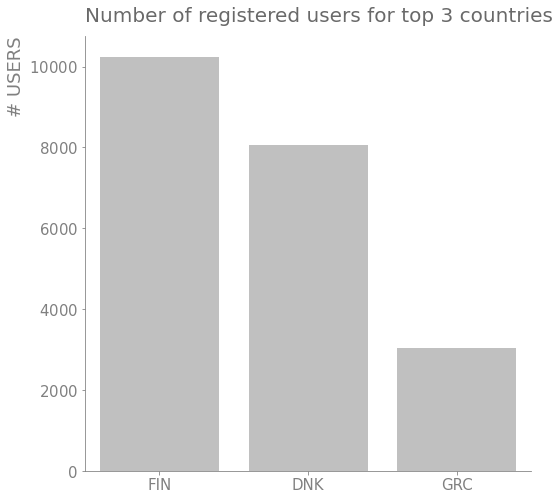

In [26]:
# Plot number of users per registration country
g = sns.countplot(data=user_data_filtered_df,
                  x="REGISTRATION_COUNTRY",
                  palette=sns.color_palette(['silver']),
                  order=['FIN', 'DNK', 'GRC']
                  )

g.set(xlabel="", ylabel="# USERS")
g.set_title("Number of registered users for top 3 countries",
            fontsize=20, loc="left", pad=14)
sns.despine()


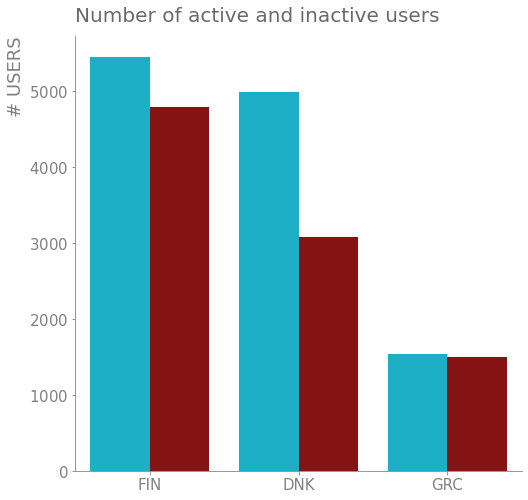

In [27]:
# Plot number of active and inactive users per registration country
g = sns.countplot(data=user_data_filtered_df,
                  x="REGISTRATION_COUNTRY",
                  palette=sns.color_palette(['#00c4e1', '#980000']),
                  order=['FIN', 'DNK', 'GRC'],
                  hue="USER_HAS_MADE_MIN_ONE_PURCHASE",
                  hue_order=["Yes", "No"]
                  )

g.set(xlabel="", ylabel="# USERS")
g.set_title("Number of active and inactive users",
            fontsize=20, loc="left", pad=14)
g.get_legend().remove()
sns.despine()


### No of users per prefered device
- On total most users prefer ios

In [28]:
# Unique preferred device corrected column
user_data_filtered_df["PREFERRED_DEVICE_CORR"].unique()

array(['ios', 'android', 'web'], dtype=object)

In [29]:
# Data frame with percentage of users per preferred device
counts = user_data_filtered_df["PREFERRED_DEVICE_CORR"].value_counts()
percent = user_data_filtered_df["PREFERRED_DEVICE_CORR"].value_counts(normalize=True)
device_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users per preferred device
device_per_df.head(10).style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,ios,9693,45.43%
1,android,8255,38.69%
2,web,3389,15.88%


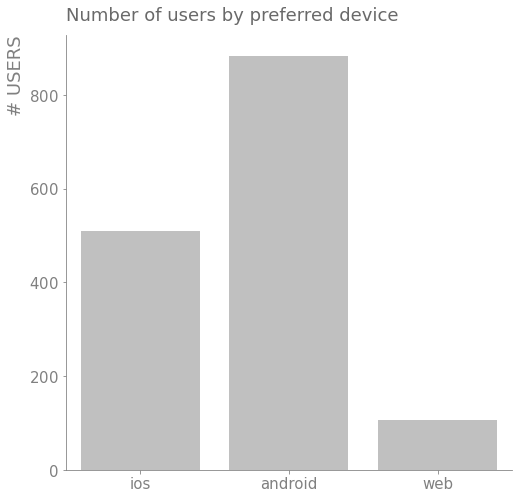

In [30]:
# Plot number of user per device
g = sns.countplot(data=user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'inactive'"),
                  x="PREFERRED_DEVICE_CORR",
                  palette=sns.color_palette(['silver']),
                  order=['ios', 'android', 'web']
                  )

g.set(xlabel="", ylabel="# USERS")
g.set_title("Number of users by preferred device",
            fontsize=18, loc="left", pad=14)
sns.despine()


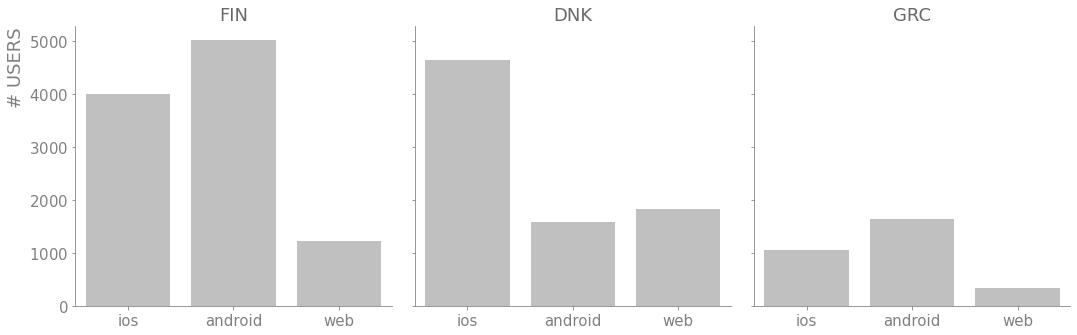

In [31]:
# Plot number of users per registration country and device
g = sns.catplot(data=user_data_filtered_df,
                x="PREFERRED_DEVICE_CORR",
                col="REGISTRATION_COUNTRY",
                kind="count",
                order=['ios', 'android', 'web'],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['silver'])
                )

g.set_ylabels("# USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### No of users per valid payment method

In [32]:
# Number of users per registration country and payment validity
user_data_filtered_df.groupby(["REGISTRATION_COUNTRY", "USER_HAS_VALID_PAYMENT_METHOD"]).agg(
    users=("USER_ID", "nunique"))


users
REGISTRATION_COUNTRY USER_HAS_VALID_PAYMENT_METHOD       
DNK                  invalid                         5212
                     valid                           2848
FIN                  invalid                         6820
                     valid                           3425
GRC                  invalid                         1794
                     valid                           1238

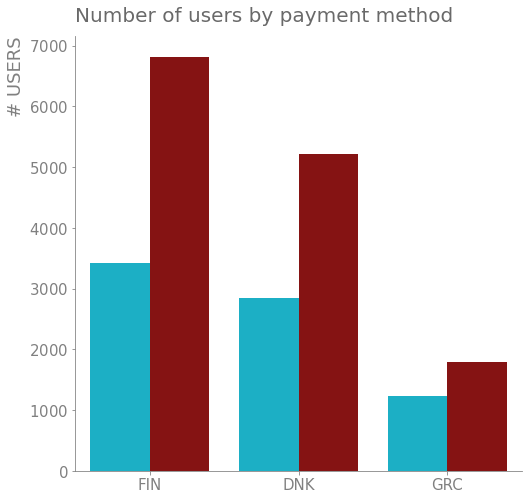

In [33]:
# Plot number of users per registration country and payment validity
g = sns.countplot(data=user_data_filtered_df,
                  x="REGISTRATION_COUNTRY",
                  palette=sns.color_palette(['#00c4e1', '#980000']),
                  order=['FIN', 'DNK', 'GRC'],
                  hue="USER_HAS_VALID_PAYMENT_METHOD",
                  hue_order=["valid", "invalid"]
                  )

g.set(xlabel="", ylabel="# USERS")
g.set_title("Number of users by payment method",
            fontsize=20, loc="left", pad=14)
g.get_legend().remove()
sns.despine()


### No of active and inactive users by country and device

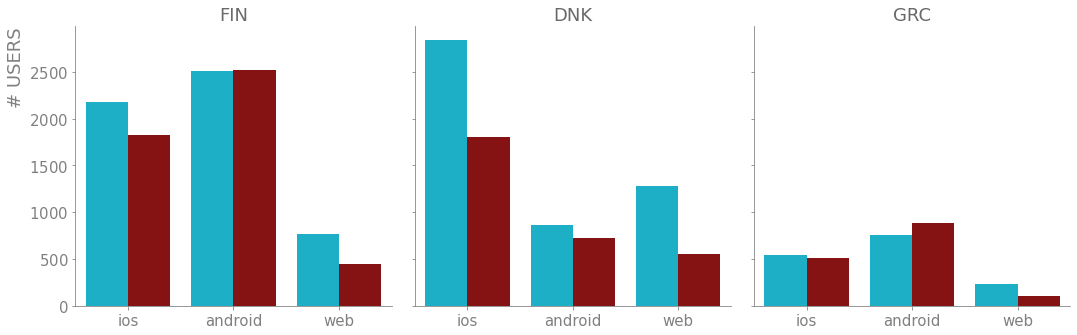

In [34]:
# Plot active and inactive users by registration country and device
g = sns.catplot(data=user_data_filtered_df,
                x="PREFERRED_DEVICE_CORR",
                col="REGISTRATION_COUNTRY",
                hue="USER_HAS_MADE_MIN_ONE_PURCHASE",
                hue_order=["Yes", "No"],
                kind="count",
                order=['ios', 'android', 'web'],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#00c4e1', '#980000']),
                legend=False
                )

g.set_ylabels("# USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### No of active and inactive users by country and payment validity

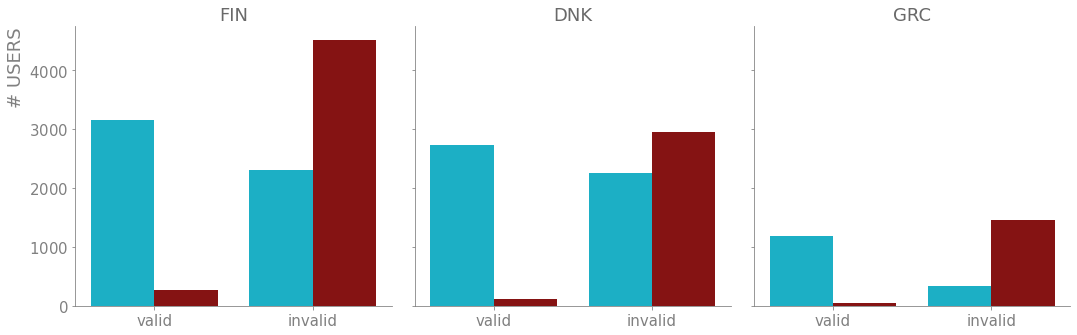

In [35]:
# Plot active and inactive users by registration country and paymeny validity
g = sns.catplot(data=user_data_filtered_df,
                x="USER_HAS_VALID_PAYMENT_METHOD",
                col="REGISTRATION_COUNTRY",
                hue="USER_HAS_MADE_MIN_ONE_PURCHASE",
                hue_order=["Yes", "No"],
                kind="count",
                order=["valid", "invalid"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#00c4e1', '#980000']),
                legend=False
                )

g.set_ylabels("# USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### Distribution of purchase count for active users

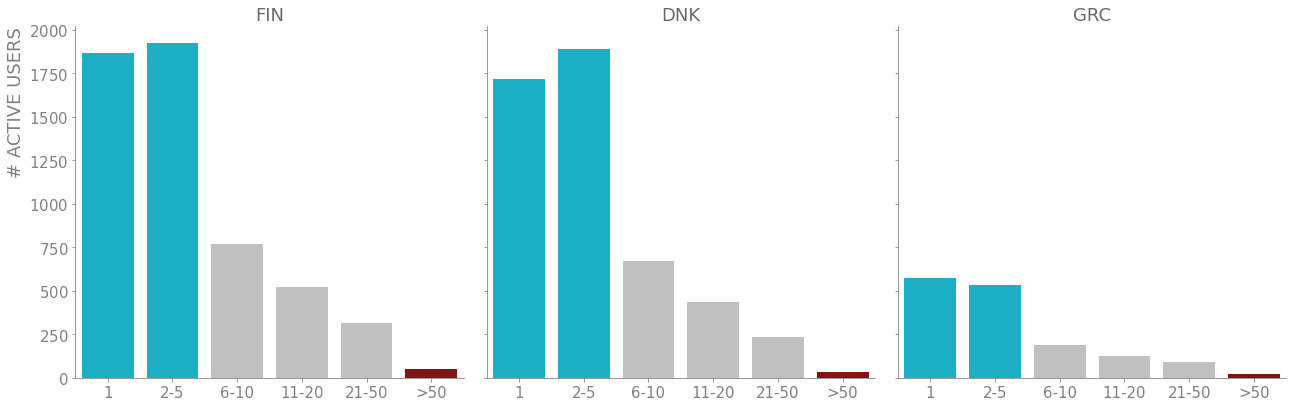

In [36]:
# Plot number of active users by registration country and purchase groups
g = sns.catplot(data=active_users_df,
                x="PURCHASE_COUNT_BIN",
                col="REGISTRATION_COUNTRY",
                kind="count",
                order=["1", "2-5", "6-10", "11-20", "21-50", ">50"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(
                    ['#00c4e1', '#00c4e1', '#C0C0C0', '#C0C0C0', '#C0C0C0', '#980000']),
                legend=False,
                col_wrap=3,
                aspect=1,
                height=6
                )

g.set_ylabels("# ACTIVE USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


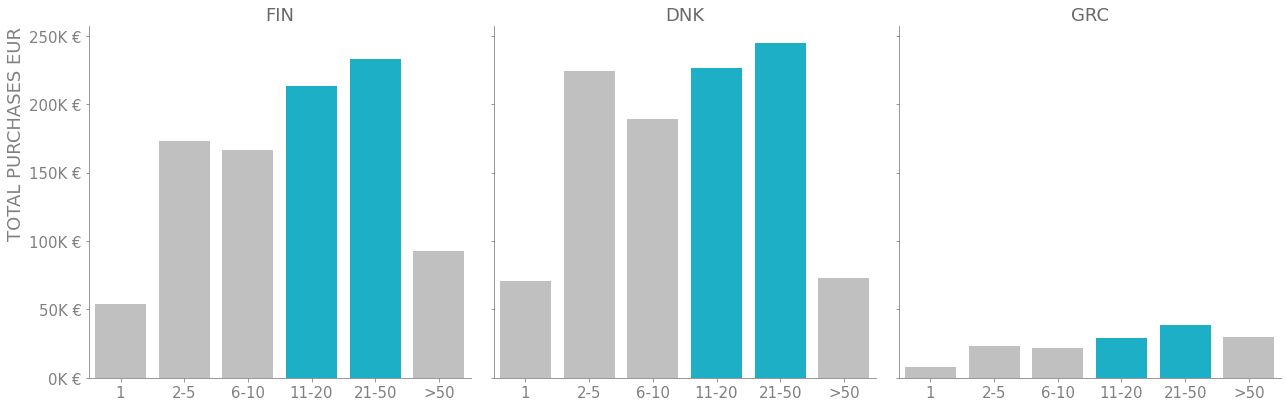

In [37]:
# Plot total purchase value in eur by registration country and purchase groups
g = sns.catplot(data=active_users_df.groupby(["REGISTRATION_COUNTRY", "PURCHASE_COUNT_BIN"]).agg(sum_purchases_eur=("TOTAL_PURCHASES_EUR", "sum")).reset_index(),
                x="PURCHASE_COUNT_BIN",
                y="sum_purchases_eur",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                order=["1", "2-5", "6-10", "11-20", "21-50", ">50"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(
                    ['#C0C0C0', '#C0C0C0', '#C0C0C0', '#00c4e1', '#00c4e1', '#C0C0C0']),
                legend=False,
                col_wrap=3,
                aspect=1,
                height=6
                )

g.set_ylabels("TOTAL PURCHASES EUR", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(
        tkr.FuncFormatter(lambda y, p: f'{y/1000:.0f}K €'))


### Distribution of avg purchase value in EUR

In [38]:
# Median and mean for avg purchase value in eur
active_users_df.groupby(["REGISTRATION_COUNTRY"]).agg(mean=(
    "AVG_PURCHASE_VALUE_EUR", "mean"), median=("AVG_PURCHASE_VALUE_EUR", "median"))


,mean,median
REGISTRATION_COUNTRY,,
DNK,39.005748,34.408
FIN,28.778599,25.300
GRC,14.479791,12.144


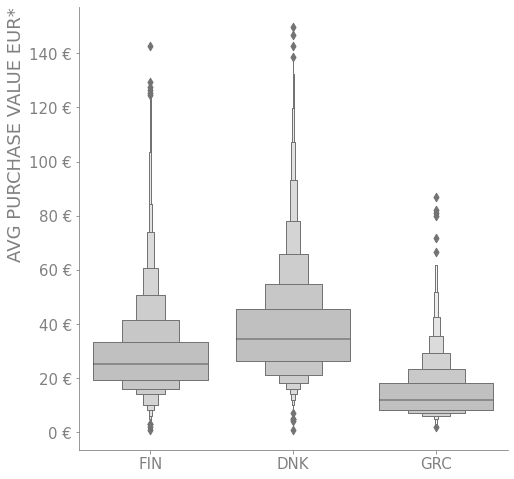

In [39]:
# Plot distribution of avg purchase value per registration country
g = sns.catplot(data=active_users_df.query("AVG_PURCHASE_VALUE_EUR <= 150"),
                x="REGISTRATION_COUNTRY",
                y="AVG_PURCHASE_VALUE_EUR",
                kind="boxen",
                order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['silver']),
                legend=False,
                height=7
                )

g.set_ylabels("AVG PURCHASE VALUE EUR*", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y:.0f} €'))


### Distribution of delivery purchases vs takeaway purchases for active users

In [40]:
# Dataframe to compare delivery vs takeaway
delivery_vs_takeaway_df = pd.melt(active_users_df[["USER_ID", "REGISTRATION_COUNTRY", "PURCHASE_COUNT_DELIVERY", "PURCHASE_COUNT_TAKEAWAY"]]
                                  .rename(columns={"PURCHASE_COUNT_DELIVERY": "delivery",
                                                   "PURCHASE_COUNT_TAKEAWAY": "takeaway"}),
                                  id_vars=["USER_ID", "REGISTRATION_COUNTRY"], value_vars=["delivery", "takeaway"], var_name="PURCHASE_TYPE", value_name="PURCHASE_COUNT"
                                  )


In [41]:
# Create columns to differentiate delivery only users and takeaway only users
active_users_df["USERS_DELIVERY_AND_TAKEAWAY"] = np.where((active_users_df["PURCHASE_COUNT_DELIVERY"] > 0) & (active_users_df["PURCHASE_COUNT_TAKEAWAY"] > 0), 1, 0)
active_users_df["USERS_DELIVERY_ONLY"] = np.where((active_users_df["PURCHASE_COUNT_DELIVERY"] > 0) & (active_users_df["PURCHASE_COUNT_TAKEAWAY"] == 0), 1, 0)
active_users_df["USERS_TAKEAWAY_ONLY"] = np.where((active_users_df["PURCHASE_COUNT_DELIVERY"] == 0) & (active_users_df["PURCHASE_COUNT_TAKEAWAY"] > 0), 1, 0)

In [42]:
# Dataframe to compare delivery vs takeaway
delivery_vs_takeaway_df_2 = (active_users_df.groupby(["REGISTRATION_COUNTRY"])
                             .agg(purchase_count_total=("PURCHASE_COUNT", "sum"),
                                  users_total=("USER_ID", "nunique"),
                                  users_delivery_and_takeaway=(
                                      "USERS_DELIVERY_AND_TAKEAWAY", "sum"),
                                  purchase_count_delivery=(
                                      "PURCHASE_COUNT_DELIVERY", "sum"),
                                  users_delivery_only=(
                                      "USERS_DELIVERY_ONLY", "sum"),
                                  purchase_count_takeaway=(
                                      "PURCHASE_COUNT_TAKEAWAY", "sum"),
                                  users_takeaway_only=(
                                      "USERS_TAKEAWAY_ONLY", "sum")
                                  )
                             .reset_index()
                             )


delivery_vs_takeaway_df_2["purchase_count_delivery_per"] = delivery_vs_takeaway_df_2["purchase_count_delivery"] / \
    delivery_vs_takeaway_df_2["purchase_count_total"]
delivery_vs_takeaway_df_2["purchase_count_takeaway_per"] = delivery_vs_takeaway_df_2["purchase_count_takeaway"] / \
    delivery_vs_takeaway_df_2["purchase_count_total"]


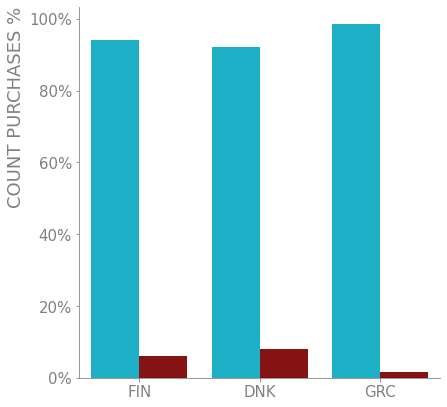

In [43]:
# Plot share of delivery vs takeaway purchases by registration country
plot_df = (delivery_vs_takeaway_df_2[["REGISTRATION_COUNTRY", "purchase_count_delivery_per", "purchase_count_takeaway_per"]]
           .melt(id_vars=['REGISTRATION_COUNTRY'], var_name='purchase_type', value_name='purchase_count_per')
           .reset_index()
           )

g = sns.catplot(data=plot_df,
                x="REGISTRATION_COUNTRY",
                y="purchase_count_per",
                hue="purchase_type",
                hue_order=["purchase_count_delivery_per", "purchase_count_takeaway_per"],
                kind="bar",
                order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#00c4e1', '#980000']),
                legend=False, 
                height=6
                )

g.set_ylabels("COUNT PURCHASES %", fontsize=18)
g.set_xlabels("")

# Format y tick labels
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:.0f}%'))


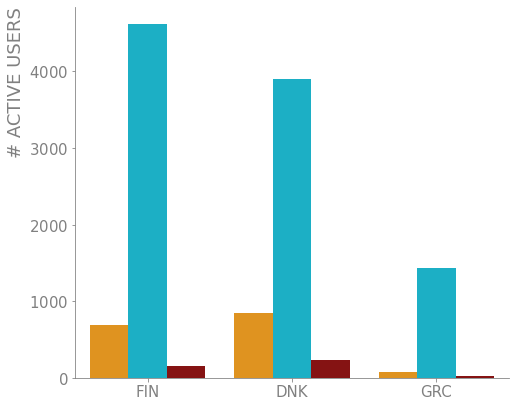

In [44]:
# Plot delivery only users, takeaway only users and deliver and takeaway users by registration country
plot_df = (delivery_vs_takeaway_df_2[["REGISTRATION_COUNTRY", "users_delivery_and_takeaway", "users_delivery_only", "users_takeaway_only"]]
           .melt(id_vars=['REGISTRATION_COUNTRY'], var_name='user_type', value_name='no_users')
           )

g = sns.catplot(data=plot_df,
                x="REGISTRATION_COUNTRY",
                y="no_users",
                hue="user_type",
                hue_order=["users_delivery_and_takeaway",
                           "users_delivery_only", "users_takeaway_only"],
                kind="bar",
                order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#ff9900', '#00c4e1', '#980000']),
                legend=False,
                height=6,
                aspect=1.2
                )

g.set_ylabels("# ACTIVE USERS", fontsize=18)
g.set_xlabels("")


### Distribution of purchases by meal type

In [45]:
# Data frame to compare purchases for breakfast, lunch, dinner and evening
meal_type_df = (active_users_df.groupby(["REGISTRATION_COUNTRY"])
                .agg(Breakfast=("BREAKFAST_PURCHASES", "sum"),
                     Lunch=("LUNCH_PURCHASES", "sum"),
                     Dinner=("DINNER_PURCHASES", "sum"),
                     Evening=("EVENING_PURCHASES", "sum"),
                     purchases_total=("PURCHASE_COUNT", "sum")
                     )
                .reset_index()
                )
meal_type_df[["Breakfast", "Lunch", "Dinner", "Evening", "purchases_total"]] = meal_type_df[[
    "Breakfast", "Lunch", "Dinner", "Evening", "purchases_total"]].div(meal_type_df["purchases_total"], axis=0)


In [46]:
meal_type_df

,REGISTRATION_COUNTRY,Breakfast,Lunch,Dinner,Evening,purchases_total
0,DNK,0.011587,0.28903,0.670151,0.028772,1.0
1,FIN,0.036496,0.45952,0.421811,0.076081,1.0
2,GRC,0.070809,0.42052,0.268593,0.235934,1.0


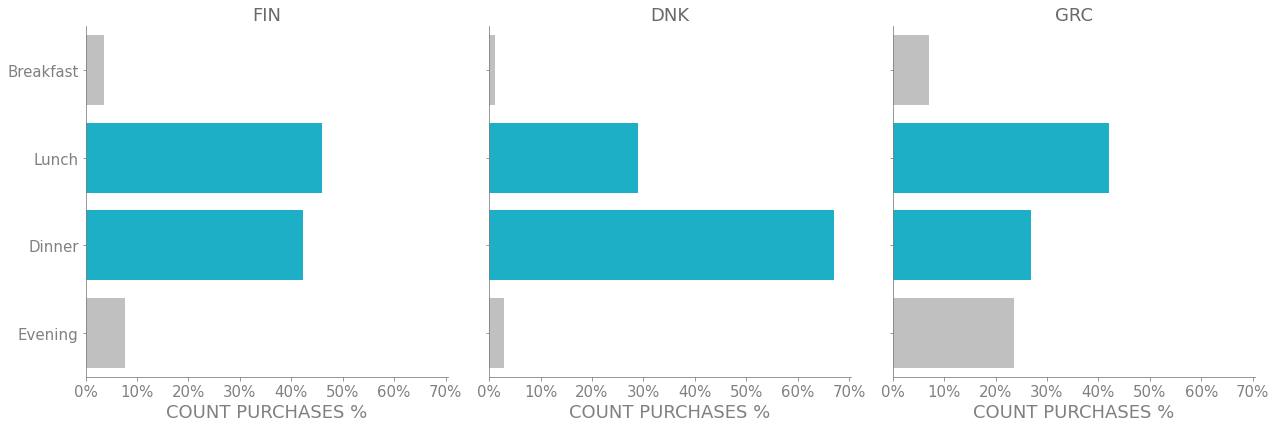

In [47]:
# Plot share of purchase for brakfast, lunch, dinner and evening
plot_df = (meal_type_df.drop("purchases_total", axis=1)
           .melt(id_vars=['REGISTRATION_COUNTRY'], var_name='meal_type', value_name='purchase_count_per')
           .reset_index()
           )

g = sns.catplot(data=plot_df,
                x="purchase_count_per",
                y="meal_type",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                order=["Breakfast", "Lunch", "Dinner", "Evening"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(
                    ['#C0C0C0', '#00c4e1', '#00c4e1', '#C0C0C0']),
                legend=False,
                height=6
                )

g.set_ylabels("", fontsize=18)
g.set_xlabels("COUNT PURCHASES %")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x, p: f'{x*100:.0f}%'))


### Distribution of users by most common hour to purchase
- This column does not make sense with an even distribution

In [48]:
# Data frame aggregated on country and most common hour to purchase
time_of_day_df = (active_users_df.groupby(["REGISTRATION_COUNTRY", "MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE"])
                  .agg(users=("USER_ID", "nunique"),
                       purchases_total=("PURCHASE_COUNT", "sum")
                       )
                  .reset_index()
                  )


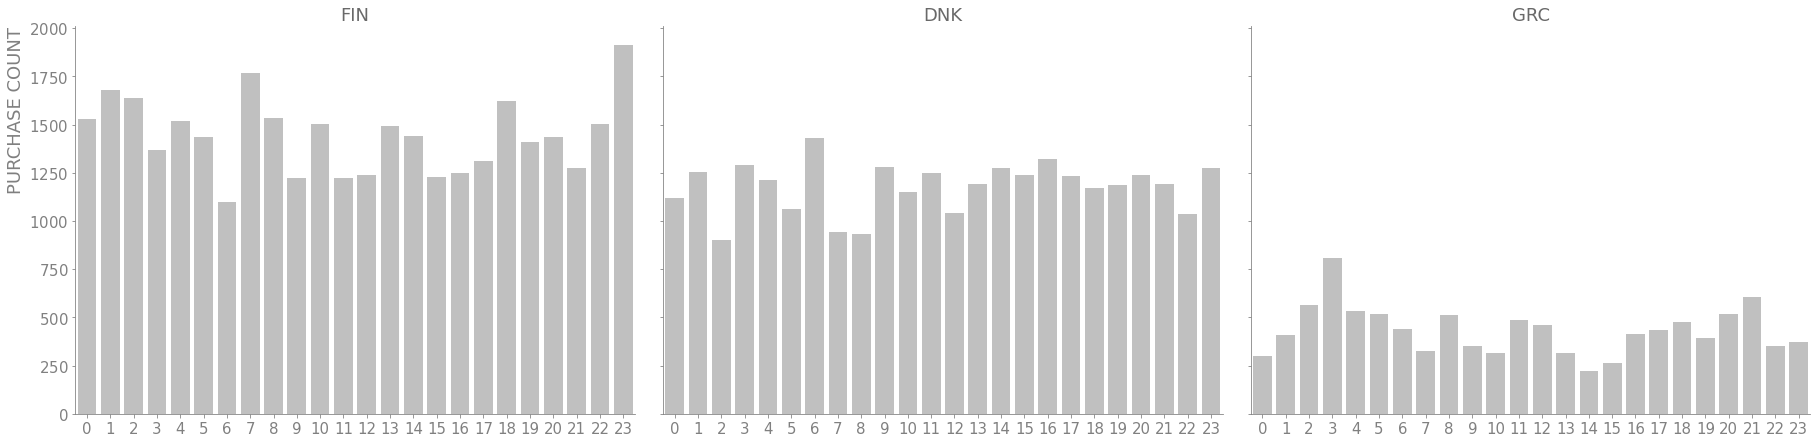

In [49]:
# Plot purchases by registration country and most common hour of day to purchase
g = sns.catplot(data=time_of_day_df,
                x="MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE",
                y="purchases_total",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#C0C0C0']),
                legend=False,
                height=6.5,
                aspect=1.3
                )

g.set_ylabels("PURCHASE COUNT", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x:.0f}'))


### Distribution of purchase venue count
- most users buy from < 5 venues

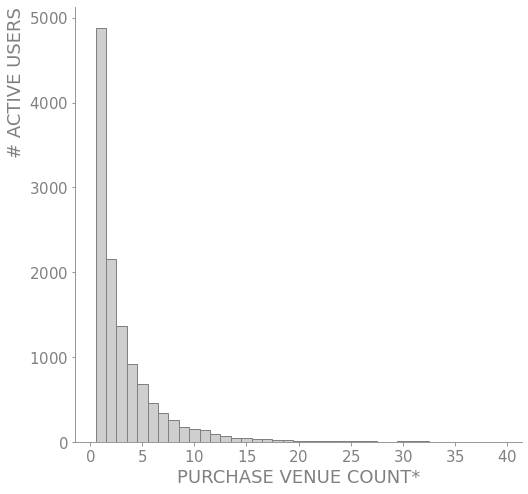

In [50]:
# Distribution of purchase venue count
g = sns.histplot(data=active_users_df.query("DISTINCT_PURCHASE_VENUE_COUNT <= 40"),
                 x="DISTINCT_PURCHASE_VENUE_COUNT",
                 stat="count",
                 palette=sns.color_palette(['silver']),
                 discrete=True
                 )

g.set(xlabel="PURCHASE VENUE COUNT*", ylabel="# ACTIVE USERS")
sns.despine()


### Distribution of purchases by weekday
- no day sticks out

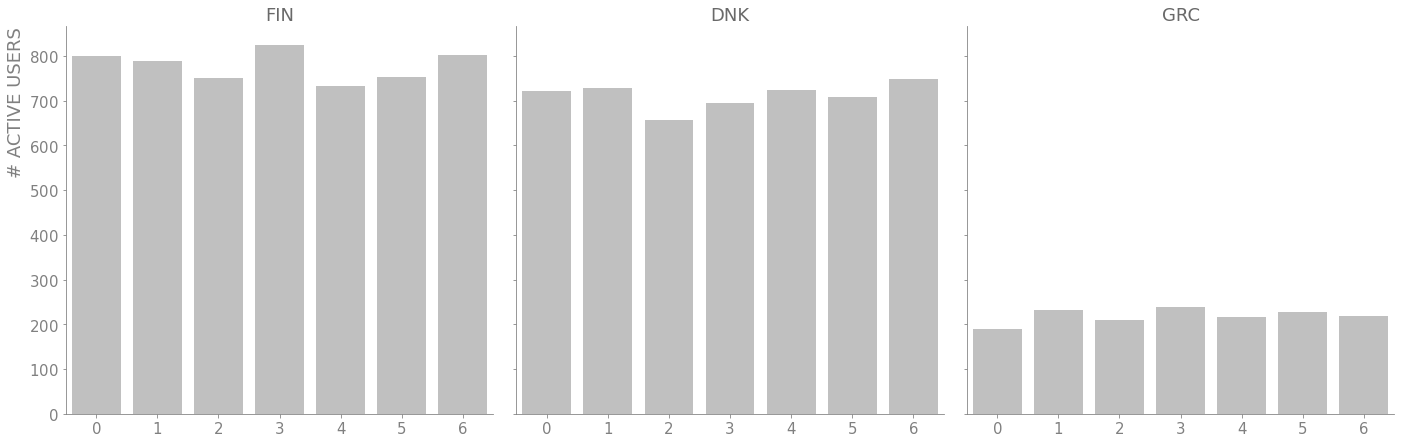

In [51]:
# Plot number of users by most common weekday to purchase
plot_df = (active_users_df.groupby(["REGISTRATION_COUNTRY", "MOST_COMMON_WEEKDAY_TO_PURCHASE"])
           .agg(users=("USER_ID", "nunique"),
                purchases_total=("PURCHASE_COUNT", "sum")
                )
           .reset_index()
           )

g = sns.catplot(data=plot_df,
                x="MOST_COMMON_WEEKDAY_TO_PURCHASE",
                y="users",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['#C0C0C0']),
                legend=False,
                height=6.5,
                aspect=1
                )

g.set_ylabels("# ACTIVE USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{x:.0f}'))


### Distribution of purchases by store type

In [52]:
# Data frame to compare purchases for diffrent store types
store_type_df = (active_users_df
                 .groupby(["REGISTRATION_COUNTRY"])
                 .agg(general_merchandise=("PURCHASE_COUNT_GENERAL_MERCHANDISE", "sum"),
                      Grocery=("PURCHASE_COUNT_GROCERY", "sum"),
                      pet_supplies=("PURCHASE_COUNT_PET_SUPPLIES", "sum"),
                      Restaurant=("PURCHASE_COUNT_RESTAURANT", "sum"),
                      retail_store=("PURCHASE_COUNT_RETAIL_STORE", "sum"),
                      purchases_total=("PURCHASE_COUNT", "sum")
                      )
                 .reset_index()
                 .rename(columns={"general_merchandise": "General merchandise",
                                  "pet_supplies": "Pet supplies",
                                  "retail_store": "Retail store"
                                  })
                 )
store_type_df[["General merchandise", "Grocery", "Pet supplies", "Restaurant", "Retail store"]] = store_type_df[[
    "General merchandise", "Grocery", "Pet supplies", "Restaurant", "Retail store"]].div(store_type_df["purchases_total"], axis=0)


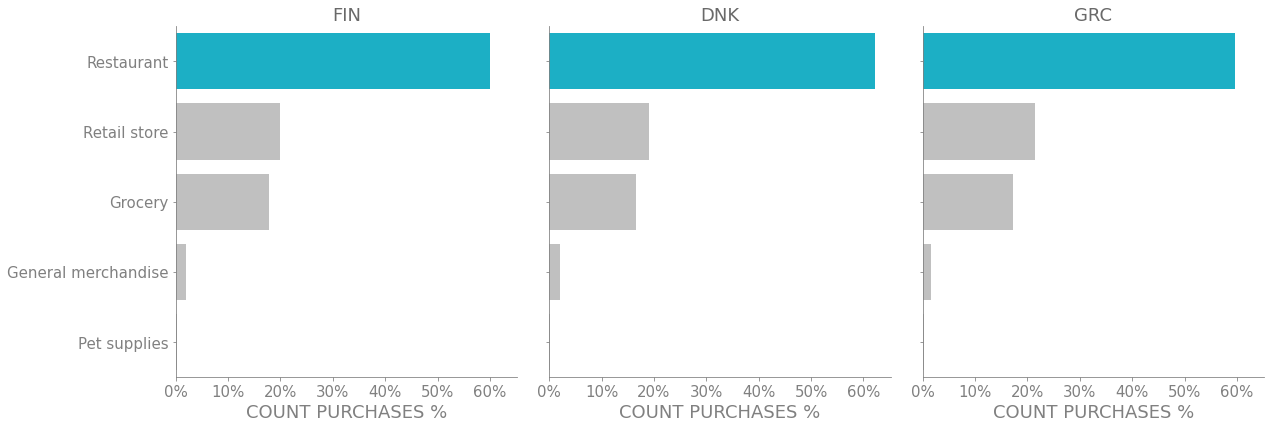

In [53]:
# Plot share of purchases by store type
plot_df = (store_type_df.drop("purchases_total", axis=1)
           .melt(id_vars=['REGISTRATION_COUNTRY'], var_name='store_type', value_name='purchase_count_per')
           .reset_index()
           )

g = sns.catplot(data=plot_df,
                x="purchase_count_per",
                y="store_type",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                order=["Restaurant", "Retail store", "Grocery",
                       "General merchandise", "Pet supplies"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(
                    ['#00c4e1', '#C0C0C0', '#C0C0C0', '#C0C0C0', '#C0C0C0']),
                legend=False,
                height=6
                )

g.set_ylabels("", fontsize=18)
g.set_xlabels("COUNT PURCHASES %")
g.set_titles("{col_name}")

# Format y tick labels
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x, p: f'{x*100:.0f}%'))


### Distribution avg days between purchases

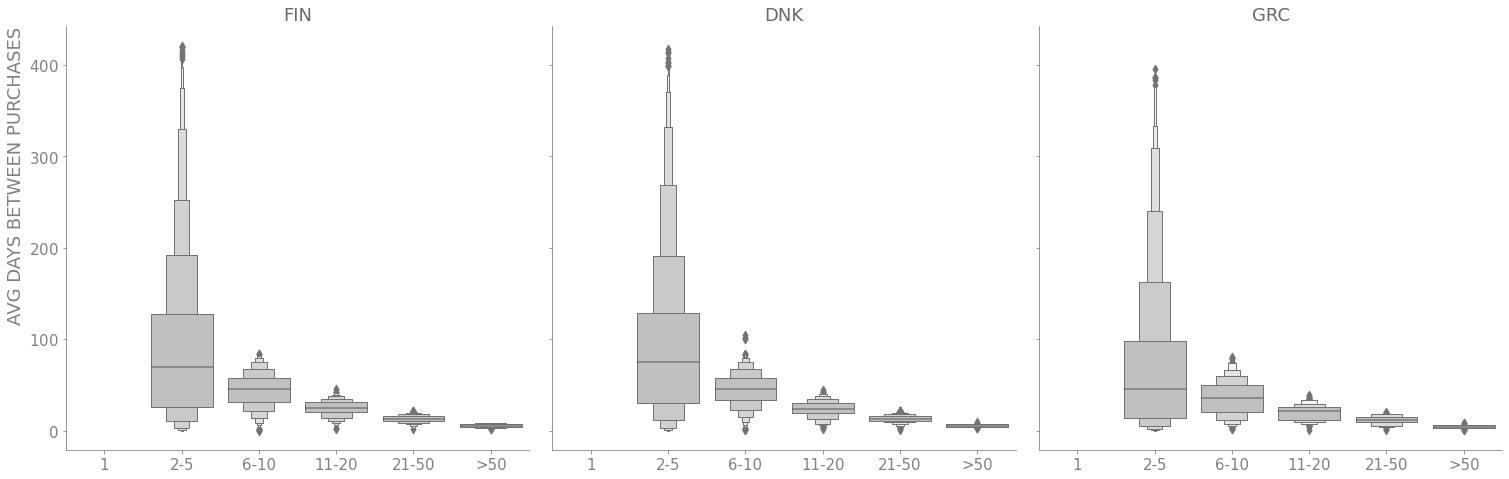

In [54]:
# Plot distribution of avg days between purchases by purchase groups and country
g = sns.catplot(data=active_users_df,
                x="PURCHASE_COUNT_BIN",
                y="AVG_DAYS_BETWEEN_PURCHASES",
                col="REGISTRATION_COUNTRY",
                kind="boxen",
                order=["1", "2-5", "6-10", "11-20", "21-50", ">50"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['silver']),
                legend=False,
                height=7
                )

g.set_ylabels("AVG DAYS BETWEEN PURCHASES", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### Distribution median days between purchases

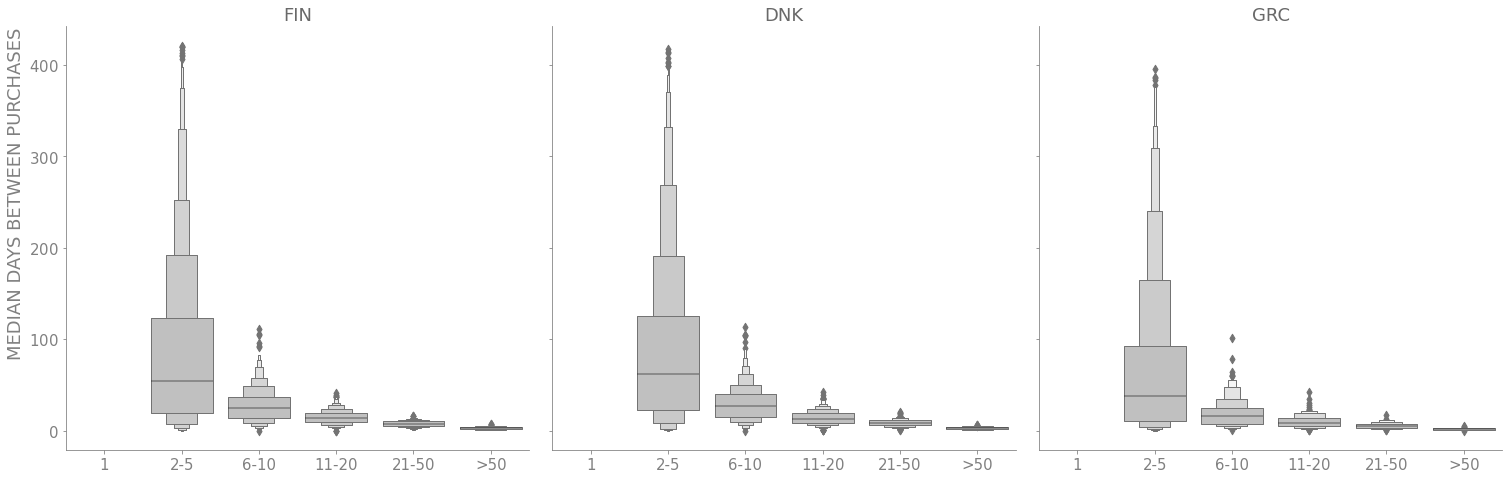

In [55]:
# Plot distribution of median days between purchases by purchase groups and country
g = sns.catplot(data=active_users_df,
                x="PURCHASE_COUNT_BIN",
                y="MEDIAN_DAYS_BETWEEN_PURCHASES",
                col="REGISTRATION_COUNTRY",
                kind="boxen",
                order=["1", "2-5", "6-10", "11-20", "21-50", ">50"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['silver']),
                legend=False,
                height=7
                )

g.set_ylabels("MEDIAN DAYS BETWEEN PURCHASES", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### Distribution avg delivery distance

In [56]:
# Column for delivery distance
active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS_BINS"] = (
    np.where((active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] < 1), "<1KM",
             np.where((active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] >= 1) & (active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] < 2), "1-2KM",
                      np.where((active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] >= 2) & (active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] < 5), "2-5KM",
                               np.where((active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] >= 5) & (active_users_df["AVERAGE_DELIVERY_DISTANCE_KMS"] < 10), "5-10KM", ">=10KM"
                                                 ))))
)

# Dataframe to check delivery distance distribution
distance_df = (active_users_df.groupby(["REGISTRATION_COUNTRY", "AVERAGE_DELIVERY_DISTANCE_KMS_BINS"])
               .agg(users=("USER_ID", "nunique"),
                    purchases_total=("PURCHASE_COUNT", "sum")
                    )
               .reset_index()
               )

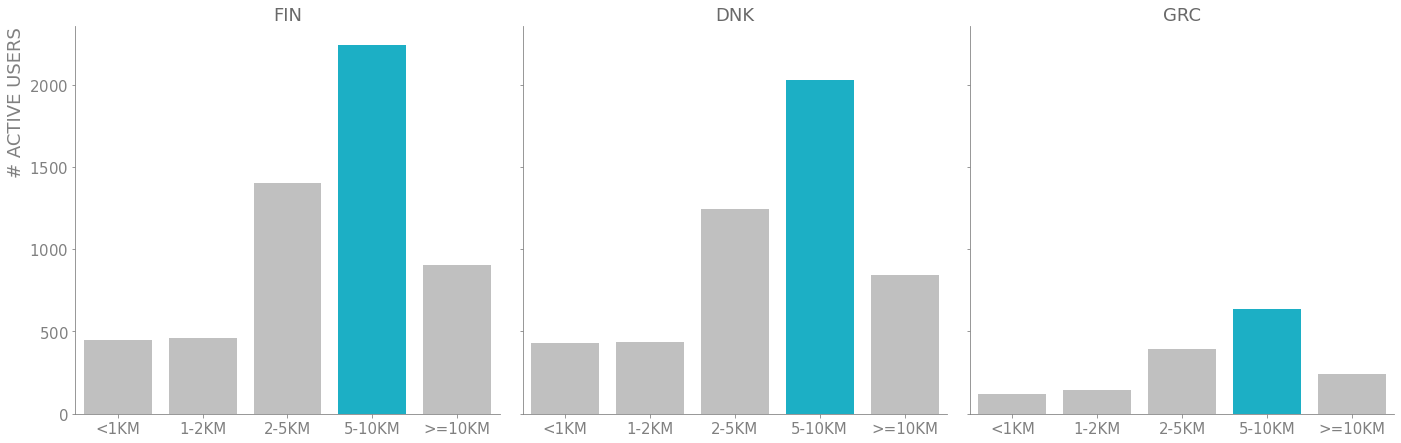

In [57]:
# Plot number of user by delivery distance groups and country
g = sns.catplot(data=distance_df,
                x="AVERAGE_DELIVERY_DISTANCE_KMS_BINS",
                y="users",
                col="REGISTRATION_COUNTRY",
                kind="bar",
                order=["<1KM", "1-2KM", "2-5KM", "5-10KM", ">=10KM"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(
                    ['#C0C0C0', '#C0C0C0', '#C0C0C0', '#00c4e1', '#C0C0C0', '#C0C0C0']),
                legend=False,
                height=6.5,
                aspect=1
                )

g.set_ylabels("# ACTIVE USERS", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")


### Distribution days from last purchase

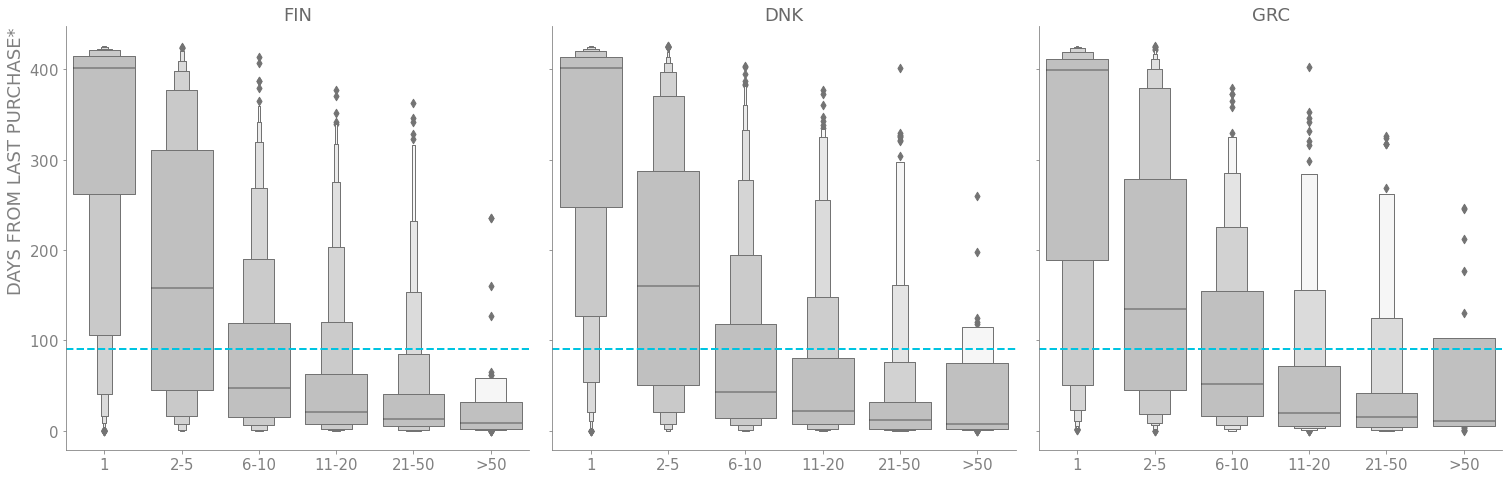

In [58]:
# Plot distribution days from last purchase by country and purchase groups
g = sns.catplot(data=active_users_df,
                x="PURCHASE_COUNT_BIN",
                y="DAYS_FROM_LAST_PURCHASE",
                col="REGISTRATION_COUNTRY",
                kind="boxen",
                order=["1", "2-5", "6-10", "11-20", "21-50", ">50"],
                col_order=["FIN", "DNK", "GRC"],
                palette=sns.color_palette(['silver']),
                legend=False,
                height=7
                )

g.set_ylabels("DAYS FROM LAST PURCHASE*", fontsize=18)
g.set_xlabels("")
g.set_titles("{col_name}")

# Add horizontal line at 90 days from last purchase
g.axes[0][0].axhline(90, ls='--', color='#00c4e1', linewidth=2)
g.axes[0][1].axhline(90, ls='--', color='#00c4e1', linewidth=2)
g.axes[0][2].axhline(90, ls='--', color='#00c4e1', linewidth=2)


# Customer segmentation

## Finland

### Users by customer segment

In [59]:
# Data frame with percentage of users
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN'")["PURCHASE_COUNT_SEGM"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN'")["PURCHASE_COUNT_SEGM"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,inactive,4794,46.79%
1,casual_shoppers,3216,31.39%
2,one_time_shoppers,1869,18.24%
3,frequent_shoppers,366,3.57%


### Inactive users by payment method

In [60]:
# Data frame with percentage of users
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,invalid,4518,94.24%
1,valid,276,5.76%


### One-time shoppers by days from last purchase

In [61]:
# Data frame with percentage of users
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,old,1658,88.71%
1,recent,211,11.29%


### Casual shoppers by days from last purchase

In [62]:
# Data frame with percentage of users
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,recent,1684,52.36%
1,old,1532,47.64%


### Frequent shoppers by days from last purchase

In [63]:
# Data frame with percentage of users
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'FIN' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,recent,326,89.07%
1,old,40,10.93%


## Denmark

### Users bys customer segment

In [64]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK'")["PURCHASE_COUNT_SEGM"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK'")["PURCHASE_COUNT_SEGM"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,inactive,3075,38.15%
1,casual_shoppers,2994,37.15%
2,one_time_shoppers,1720,21.34%
3,frequent_shoppers,271,3.36%


### Inactive users by payment method

In [65]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,invalid,2959,96.23%
1,valid,116,3.77%


### One-time shoppers by days from last purchase

In [66]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,old,1555,90.41%
1,recent,165,9.59%


### Casual shoppers by days from last purchase

In [67]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,old,1526,50.97%
1,recent,1468,49.03%


### Frequent shoppers by days from last purchase

In [68]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'DNK' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,recent,240,88.56%
1,old,31,11.44%


## Greece

### Users by customer segment

In [69]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC'")["PURCHASE_COUNT_SEGM"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC'")["PURCHASE_COUNT_SEGM"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users per 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,inactive,1500,49.47%
1,casual_shoppers,847,27.94%
2,one_time_shoppers,574,18.93%
3,frequent_shoppers,111,3.66%


### Inactive users by payment method

In [70]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'inactive'")["USER_HAS_VALID_PAYMENT_METHOD"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,invalid,1454,96.93%
1,valid,46,3.07%


### One-time shoppers by days from last purchase

In [71]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'one_time_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,old,482,83.97%
1,recent,92,16.03%


### Casual shoppers by days from last purchase

In [72]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'casual_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,old,440,51.95%
1,recent,407,48.05%


### Frequent shoppers by days from last purchase

In [73]:
# Data frame with percentage of users 
counts = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts()
percent = user_data_filtered_df.query("REGISTRATION_COUNTRY == 'GRC' and PURCHASE_COUNT_SEGM == 'frequent_shoppers'")["DAYS_FROM_LAST_PURCHASE_segm"].value_counts(normalize=True)
user_per_df = pd.DataFrame({'Users': counts, 'Percentage': percent}).reset_index()

# Percentage of users 
user_per_df.style.format({'Percentage': "{:.2%}"})

,index,Users,Percentage
0,recent,90,81.08%
1,old,21,18.92%


## Visualize the 4 customer segments

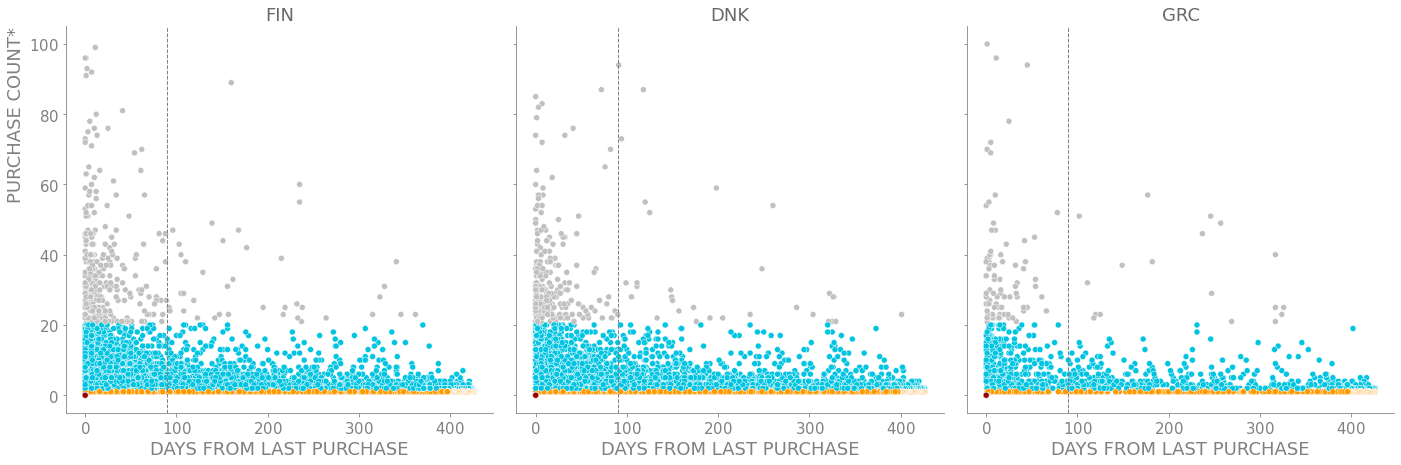

In [74]:
# Scatter plot for purchase count vs days from last purchase
g = sns.relplot(data=user_data_filtered_df.fillna(0).query("PURCHASE_COUNT <= 100"),
                    x="DAYS_FROM_LAST_PURCHASE",
                    y="PURCHASE_COUNT",
                    hue="PURCHASE_COUNT_SEGM",
                    hue_order=["inactive", "one_time_shoppers",
                               "casual_shoppers", "frequent_shoppers"],
                    col="REGISTRATION_COUNTRY",
                    col_order=["FIN", "DNK", "GRC"],
                    palette=sns.color_palette(
                        ['#980000', '#ff9900', '#00c4e1', '#C0C0C0']),
                    legend=False, 
                    height=6.5
                    )

g.set_xlabels("DAYS FROM LAST PURCHASE", fontsize=18)
g.set_ylabels("PURCHASE COUNT*")
g.set_titles("{col_name}")

# Add horizontal line at 90 days from last purchase
g.axes[0][0].axvline(90, ls='--', color='gray', linewidth=1)
g.axes[0][1].axvline(90, ls='--', color='gray', linewidth=1)
g.axes[0][2].axvline(90, ls='--', color='gray', linewidth=1)

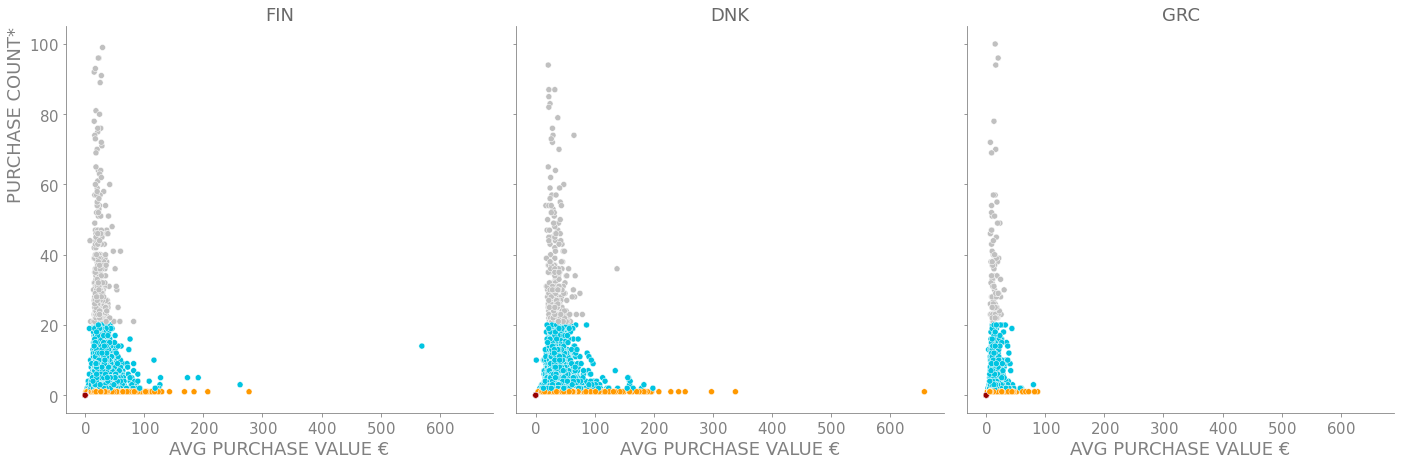

In [75]:
# Scatter plot for purchase count vs days from last purchase
g = sns.relplot(data=user_data_filtered_df.fillna(0).query("PURCHASE_COUNT <= 100"),
                    x="AVG_PURCHASE_VALUE_EUR",
                    y="PURCHASE_COUNT",
                    hue="PURCHASE_COUNT_SEGM",
                    hue_order=["inactive", "one_time_shoppers",
                               "casual_shoppers", "frequent_shoppers"],
                    col="REGISTRATION_COUNTRY",
                    col_order=["FIN", "DNK", "GRC"],
                    palette=sns.color_palette(
                        ['#980000', '#ff9900', '#00c4e1', '#C0C0C0']),
                    legend=False, 
                    height=6.5
                    )

g.set_xlabels("AVG PURCHASE VALUE €", fontsize=18)
g.set_ylabels("PURCHASE COUNT*")
g.set_titles("{col_name}")

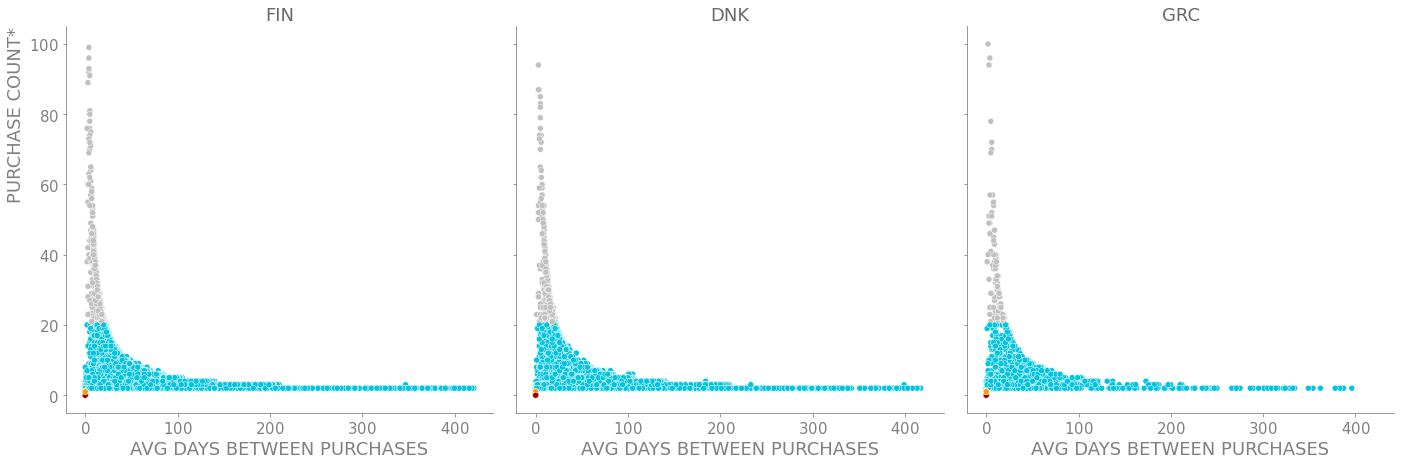

In [76]:
# Scatter plot for purchase count vs days from last purchase
g = sns.relplot(data=user_data_filtered_df.fillna(0).query("PURCHASE_COUNT <= 100"),
                    x="AVG_DAYS_BETWEEN_PURCHASES",
                    y="PURCHASE_COUNT",
                    hue="PURCHASE_COUNT_SEGM",
                    hue_order=["inactive", "one_time_shoppers",
                               "casual_shoppers", "frequent_shoppers"],
                    col="REGISTRATION_COUNTRY",
                    col_order=["FIN", "DNK", "GRC"],
                    palette=sns.color_palette(
                        ['#980000', '#ff9900', '#00c4e1', '#C0C0C0']),
                    legend=False, 
                    height=6.5
                    )

g.set_xlabels("AVG DAYS BETWEEN PURCHASES", fontsize=18)
g.set_ylabels("PURCHASE COUNT*")
g.set_titles("{col_name}")

## Correlation matrix

In [77]:
active_users_df.corr()

,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_GENERAL_MERCHANDISE,PURCHASE_COUNT_GROCERY,PURCHASE_COUNT_PET_SUPPLIES,PURCHASE_COUNT_RESTAURANT,PURCHASE_COUNT_RETAIL_STORE,DAYS_FROM_LAST_PURCHASE,DAYS_TO_FIRST_PURCHASE,USERS_DELIVERY_AND_TAKEAWAY,USERS_DELIVERY_ONLY,USERS_TAKEAWAY_ONLY
PURCHASE_COUNT,1.000000,0.991393,0.224383,0.000886,0.466051,0.878972,0.503023,0.830821,0.855384,0.787353,-0.204555,0.137844,-0.064902,0.612647,0.457862,0.583003,-0.001962,-0.004964,-0.305745,-0.294965,-0.018926,0.225843,0.656525,0.493244,0.989695,0.693619,-0.378642,-0.130764,0.194780,-0.139683,-0.076715
PURCHASE_COUNT_DELIVERY,0.991393,1.000000,0.094869,0.000954,0.463145,0.874791,0.507735,0.816547,0.843597,0.771705,-0.194976,0.127776,-0.065450,0.603275,0.457897,0.579659,-0.003448,-0.006405,-0.297395,-0.286408,-0.020014,0.212339,0.652253,0.494935,0.981968,0.686133,-0.363726,-0.128218,0.126432,-0.064482,-0.103365
PURCHASE_COUNT_TAKEAWAY,0.224383,0.094869,1.000000,-0.000366,0.096348,0.172035,0.045565,0.239437,0.224867,0.242700,-0.104094,0.097041,-0.006327,0.167972,0.073141,0.118351,0.010744,0.009926,-0.095551,-0.095767,0.005065,0.136721,0.137054,0.066488,0.216183,0.166919,-0.171722,-0.039880,0.539971,-0.582150,0.186074
USER_ID,0.000886,0.000954,-0.000366,1.000000,-0.011127,0.000965,0.006430,0.000197,0.010917,0.000334,0.016646,0.015501,0.019232,-0.009921,0.005430,0.008355,0.005626,0.009315,0.007603,0.008661,0.008287,0.006311,0.002232,-0.002893,0.001600,-0.002159,-0.052838,-0.020380,-0.000535,-0.000050,0.001097
BREAKFAST_PURCHASES,0.466051,0.463145,0.096348,-0.011127,1.000000,0.478223,0.187522,0.163122,0.297057,0.284730,-0.081023,0.037601,-0.039630,0.254838,0.283876,0.255949,-0.009283,0.010773,-0.102017,-0.099031,-0.009704,0.057381,0.295129,0.202067,0.468707,0.328696,-0.113583,-0.030768,0.044281,-0.031040,-0.018903
LUNCH_PURCHASES,0.878972,0.874791,0.172035,0.000965,0.478223,1.000000,0.301630,0.521552,0.700791,0.613444,-0.175864,0.080801,-0.082317,0.491965,0.429998,0.543686,0.001396,0.000089,-0.238481,-0.229557,-0.011423,0.161580,0.588654,0.440141,0.874046,0.596594,-0.295659,-0.097004,0.125372,-0.086288,-0.056784
EVENING_PURCHASES,0.503023,0.507735,0.045565,0.006430,0.187522,0.301630,1.000000,0.313993,0.305800,0.417115,-0.156006,-0.005123,-0.118711,0.342379,0.187985,0.285643,-0.010535,-0.009884,-0.150364,-0.144322,-0.007089,0.103803,0.293011,0.214955,0.499282,0.383261,-0.169233,-0.032371,0.033069,-0.007784,-0.045614
DINNER_PURCHASES,0.830821,0.816547,0.239437,0.000197,0.163122,0.521552,0.313993,1.000000,0.830119,0.748260,-0.157929,0.187892,0.005430,0.553204,0.351954,0.456272,0.000505,-0.008831,-0.285987,-0.276630,-0.021711,0.240726,0.548937,0.419822,0.815806,0.576530,-0.374839,-0.146685,0.244172,-0.184832,-0.076268
TOTAL_PURCHASES_EUR,0.855384,0.843597,0.224867,0.010917,0.297057,0.700791,0.305800,0.830119,1.000000,0.753131,-0.075587,0.475384,0.197364,0.547057,0.399064,0.468621,0.006094,-0.009797,-0.280621,-0.273063,-0.017774,0.247686,0.568534,0.417993,0.841196,0.589337,-0.385042,-0.144617,0.235395,-0.174344,-0.081390
DISTINCT_PURCHASE_VENUE_COUNT,0.787353,0.771705,0.242700,0.000334,0.284730,0.613444,0.417115,0.748260,0.753131,1.000000,-0.233655,0.208915,-0.030855,0.571050,0.328319,0.385362,0.008164,-0.016784,-0.307069,-0.310207,-0.020170,0.317173,0.493779,0.344836,0.769609,0.569756,-0.461955,-0.145713,0.283358,-0.206715,-0.104422
